# Conditional GAN MinPrj

<title>Conditional GAN</title>
<li>author : bae hueng myoung</li>
<li>date : 7 dec 2021</li>
<li>



## Introduction 
새로운 이미지를 생성할 때 GAN은 노이즈를 이용하여 비슷한 이미지를 놀라운 수준으로 생성하였다. 하지만 gan은 사용자가 원하는 세밀한 이미지를 생성하는데 한계점이 명확이 드러났었고 이러한 문제를 해결하기 위해 원하는 결과값을 얻을 때 까지 수많은 노이즈로 매번 학습시키는 일은 매우 비효율적인 일이다. 이번 Conditional GAN은 사용자가 원하는 세밀한 스타일의 이미지를 생성하기 위해 하나의 가이드라인의 역할을 하는 이미지를 함께 학습시켜 보다 사용자의 의도에 맞는 이미지를 생성하는데 효과를 나타내었다. 따라서 이번 프로젝트는 총 1000장의 도로환경 사진을 이용하여 이를 실험해볼 것이다.

In [57]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

folder_path = os.getenv('HOME') + '/aiffel/exp19_conditional_generation'
train_folder = '/cityscapes/train/'
val_folder = '/cityscapes/val/'

train_path = folder_path + train_folder
val_path = folder_path + val_folder



train_path

'/aiffel/aiffel/exp19_conditional_generation/cityscapes/train/'

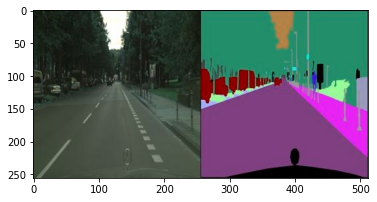

In [58]:
sample = cv2.imread(train_path+'/7.jpg')
plt.imshow(sample)
plt.show()

## getting of imgs

In [59]:
print("number of train examples :", len(os.listdir(train_path)))

number of train examples : 1000


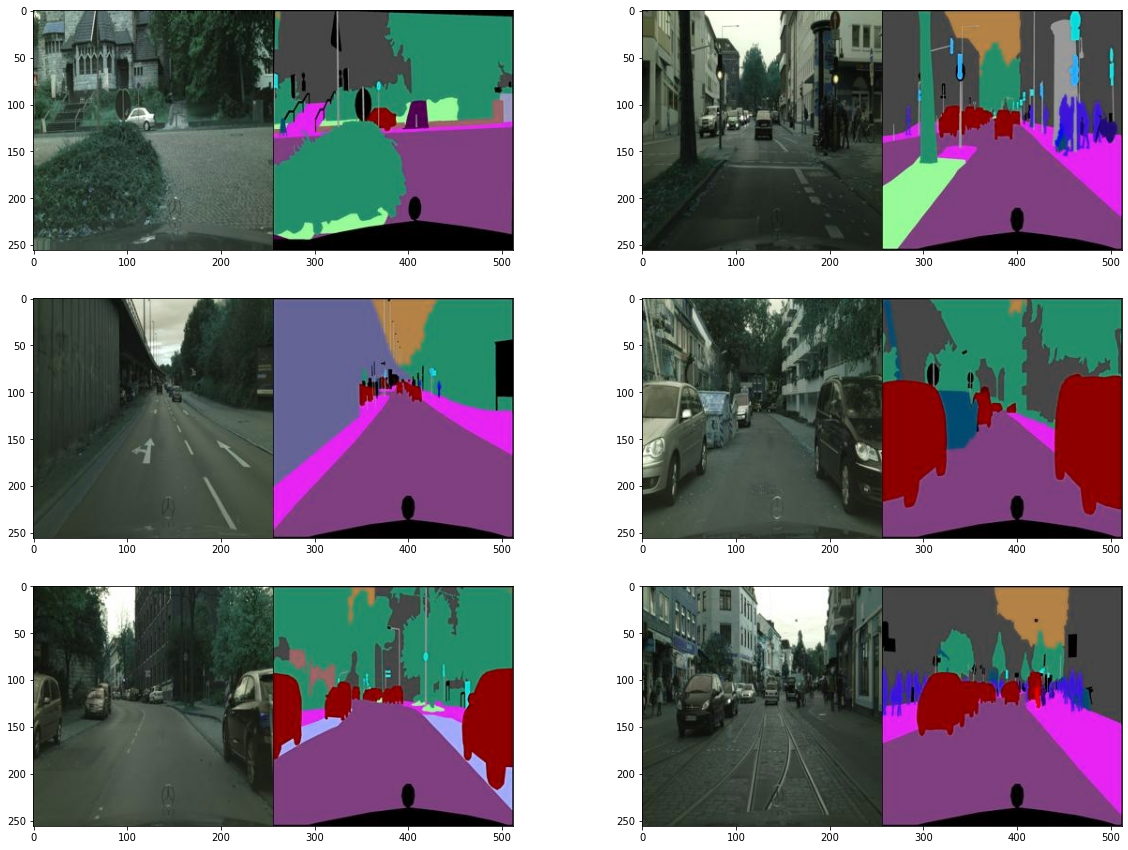

In [60]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_path + os.listdir(train_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)


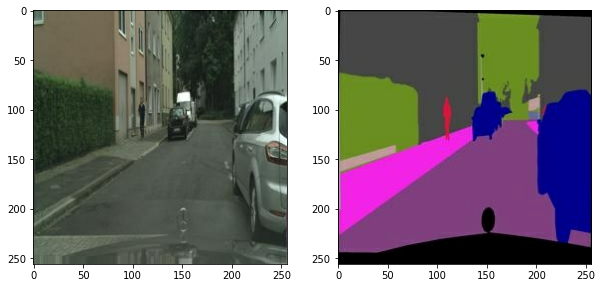

In [61]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = train_path + os.listdir(train_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## Applying Augmentation

In [62]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


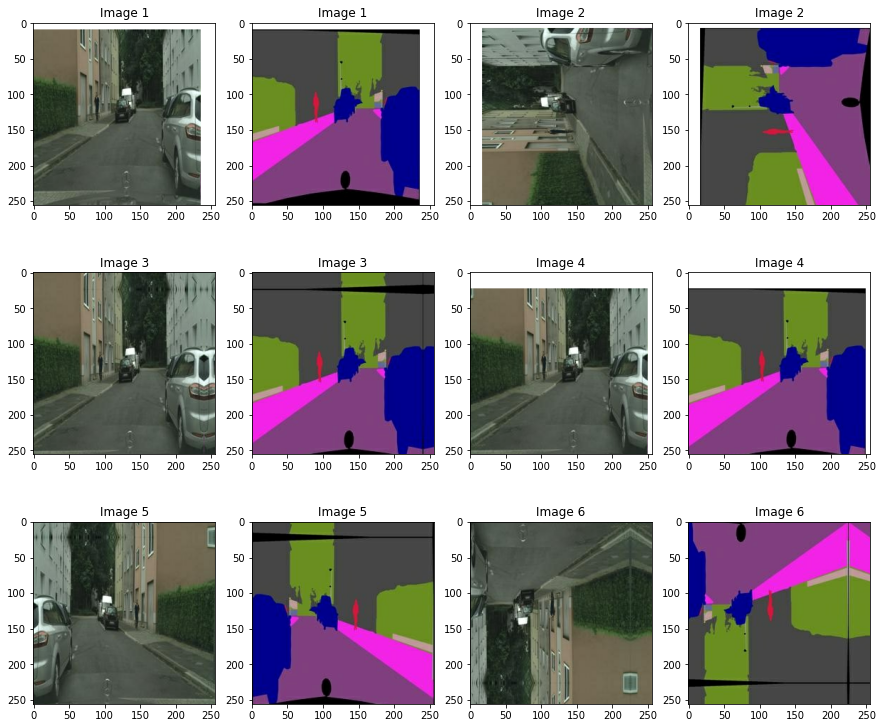

In [63]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

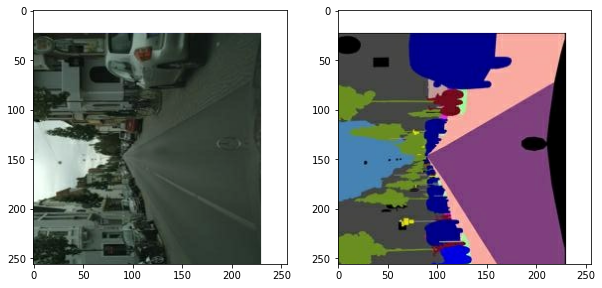

In [64]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## Generator Encoder Design

In [65]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [66]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [67]:
UNetGenerator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_48 (EncodeBlock)   (None, 128, 128, 64) 3072        input_6[0][0]                    
__________________________________________________________________________________________________
encode_block_49 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_48[0][0]            
__________________________________________________________________________________________________
encode_block_50 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_49[0][0]            
____________________________________________________________________________________________

## discirminator 

In [68]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [69]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_11 (ZeroPaddi (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_114 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_77 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [70]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [71]:
Discriminator().get_summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_61 (Concatenate)    (None, 256, 256, 6)  0           input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
disc_block_25 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_61[0][0]       

## loss function defenition

In [72]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [73]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [74]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


## Training 10 epochs

In [75]:
EPOCHS = 20

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.2234                     
L1_loss:0.3858                     
Discriminator_loss:1.5561

EPOCH[1] - STEP[20]                     
Generator_loss:0.9930                     
L1_loss:0.2750                     
Discriminator_loss:1.1908

EPOCH[1] - STEP[30]                     
Generator_loss:1.1346                     
L1_loss:0.2575                     
Discriminator_loss:1.0615

EPOCH[1] - STEP[40]                     
Generator_loss:1.3192                     
L1_loss:0.2459                     
Discriminator_loss:0.7637

EPOCH[1] - STEP[50]                     
Generator_loss:1.7078                     
L1_loss:0.2372                     
Discriminator_loss:0.6786

EPOCH[1] - STEP[60]                     
Generator_loss:1.7823                     
L1_loss:0.2566                     
Discriminator_loss:0.3745

EPOCH[1] - STEP[70]                     
Generator_loss:1.4339                     
L1_loss:0.2101                    

## test of validation img data

In [76]:
def UnetTest(f):
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [77]:
print('validation data length : ', len(os.listdir(val_path)))

validation data length :  5


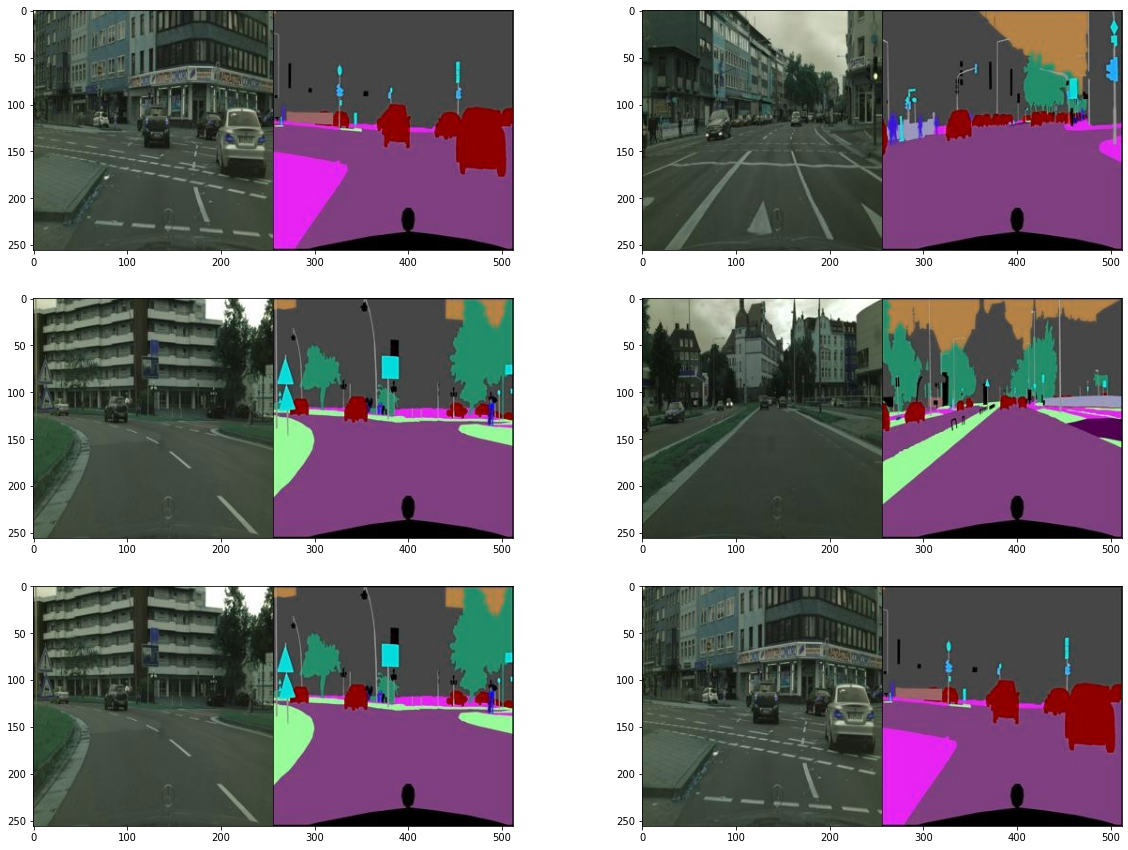

In [78]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_path + os.listdir(val_path)[np.random.randint(5)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

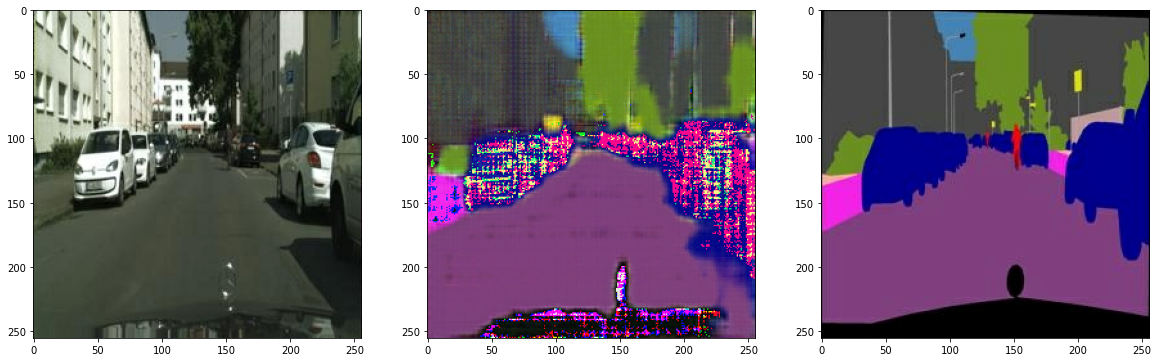

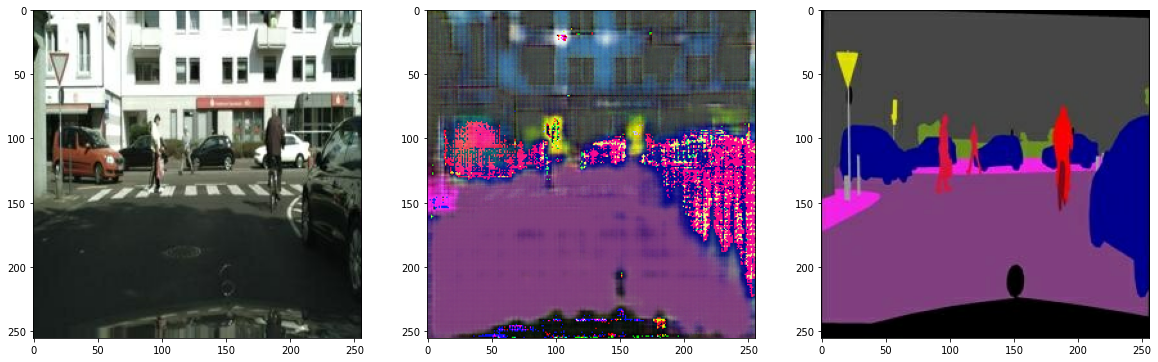

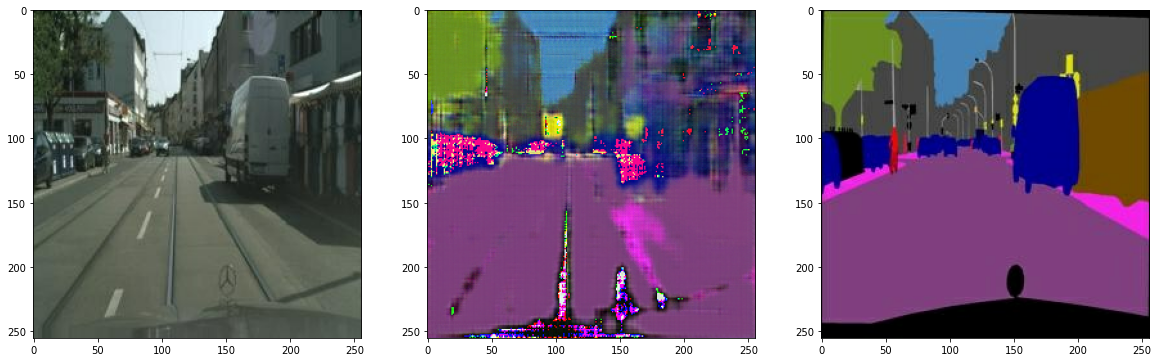

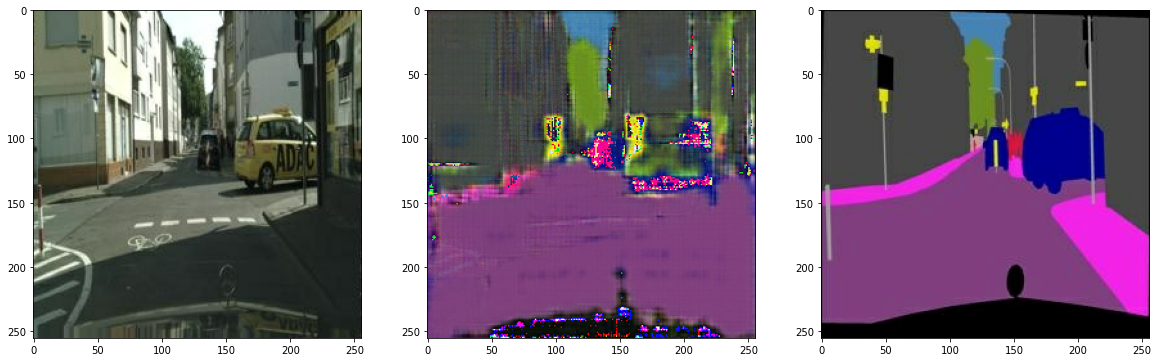

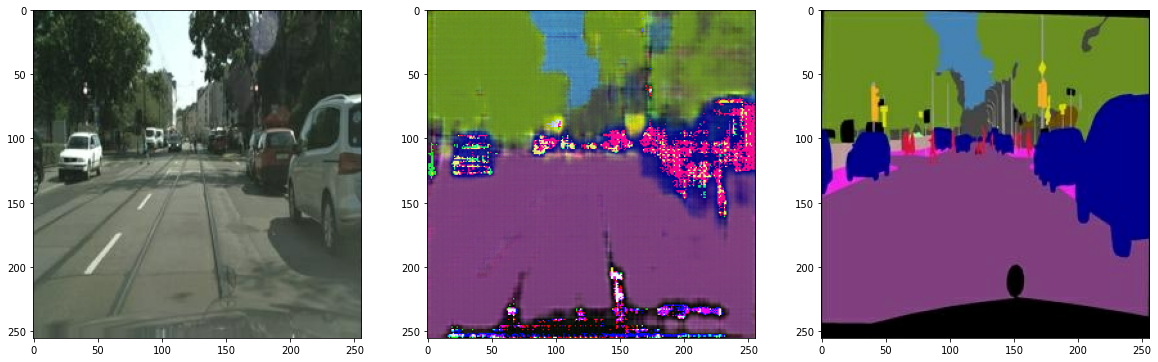

In [79]:
for i in range(5):
    fv = val_path + os.listdir(val_path)[i]
    UnetTest(fv)

## Analysis : 

학습에 유리하도록 데이터의 다양성을 높이기 위해 augmentation을 이용하여 90도 좌우 플립의 과정을 거쳤다. 그리고 이미지를 잘 생성시키기 위해 U-net 구조의 모델을 설계하였다. LMS의 설명과 같이 U-net은 pix2pix기법에서 일반적인 encoder, decoder의 설계에 비해 decoder가 이미지를 더욱 잘 생성시키기 위해 skip connection을 추가하였고 이를 앞선 practice에서 실험해볼 수 있었다. 하지만 이번 프로젝트의 결과는 그리 좋은 성능을 나타내지 못하였다. 이러한 이유는 이전 프랙타이스와 비교해볼 때 이미지 생성 난이도의 차이에서 비롯된 것임을 조심스럽게 추정할 수 있다. 이전 프랙타이스는 숫자, 포켓몬 이미지의 단순한 이미지들이였고 포켓몬 이미지의 cGAN의 결과는 6살 짜리 어린이보다도 못한 색칠 능력을 보여주었지만 이미지의 색칠은 어느정도 일관성이 있어 보였다. 그에 반해 실제 일반 도로환경들은 매우 복잡하고 학습하는데 매우 많은 비용이 들어가야만 한다. 차선, 차량, 나무, 도로의 크랙, 건물 등의 이미지의 복잡성은 이미지를 생성하는데 단순한 이미지보다도 어려울 것이기 떄문이다. 


## In my opinion
    이미지를 생성하는 창조의 영역은 인간 고유의 영역이라 여겨져왔다. 하지만 exploration의 GAN 알고리즘을 살펴보면서 생각보다 창조의 영역 부분에서 기계가 새로운 이미지를 생성하는 결과들을 보면서 창조의 영역에 대해 다시한번 생각해보는 계기가 되었다. 그리고 나는 아직까지 기계는 창조적이지 않다고 생각한다. 그 이유는 이제까지의 알고리즘은 사람의 페인팅, 작문과 비교해볼 때 말 그대로 "기계적"이기 떄문이다. 사람은 무언가를 행위할 때 목적성을 갖는다. 글을 쓸 때 일련의 목적을 갖고 일을 수행하며 페인팅을 할 때에도 머릿속의 구체적이지 않지만 표현 의도에 입각하여 적절한 행위를 수행한다. 그에 비해 기계는 인간보다 훨씬 적은 목적을 갖고 있으며 스스로 목적을 생성하여 일을 수행하지 않아 보인다. 만약 기계가 충분한 목적을 갖고 일을 수행할 수 있다면 오늘 해본 색칠의 결과에서 6살 짜리 어린이보다 못한 그림실력을 보여줄리 없기 때문이다. 
    
    끝으로, 복잡한 알고리즘으로 구성되었지만 단순하고 불충분한 목적에 입각한 머신러닝에 대해서 나는 경계한다. 이제까지 lms exploration, fundamental을 하면서 인공지능이 가져올 이익보다 인공지능에 의한 다른 문제들에 대해 우려하고 있다. 딥페이크의 문제, 소피아의 인류를 몰살시키려는 의도를 갖는 대화들은 과연 인공지능이 참된 이익을 위해 통제력을 발휘할 수 있을지 의문을 갖게 만든다. 그리고 사람이 기술에 대해서 통제력을 갖지 못하는 사례들을 보면서 인공지능 마저 사람이 통제하기 어려울 수 있다는 우려스러운 생각이 든다. 예로써, 스마트폰에 대해서 다수의 사람들은 이를 잘 통제하지 못하고 있다. 스마트폰이 주는 영상과 웹페이지들은 인간의 정보과부하를 유발시키며 점점 원시시대의 주의 결핍을 야기시킨다. 스마트폰이 주는 안락감, 쾌락에 의해 고등적 통제기능을 담당하는 전두엽을 마비키시지만 스스로 이러한 문제에 대해서 의식적이지 않으며 통제하기 어렵다. 따라서 나는 보다 인류와 기계가 공존하며 사람이 기계를 통제할 수 있는 보조적인 인공지능에 대해 관심을 두고 있다.